## Mitchell-Schaeffer - Replicated Paper
This is an attempt to replicate the results of the original paper, using their parameters.

Model is Mitchell-Schaeffer as shown in Eqn 1-4 from 
https://doi.org/10.1016/S0092-8240(03)00041-7

$$\frac{dv}{dt}=\frac{hv^2(1-v)}{\tau_{in}} - \frac{v}{\tau_{out}}$$

$$
\frac{dh}{dt} = \left\{
        \begin{array}{ll}
            \frac{-h}{\tau_{close}} & \quad v \geq v_{gate} \\
            \frac{1-h}{\tau_{open}} & \quad v < v_{gate}
        \end{array}
    \right.
$$

Code adapted from: giuseppebonaccorso/hodgkin-huxley-main.py on gist:
https://gist.github.com/giuseppebonaccorso/60ce3eb3a829b94abf64ab2b7a56aaef


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

In [2]:
# h steady-state value
def h_inf(Vm=0.0):
    return 1 # TODO??
  
# Input stimulus
def Id(t):
    if 5.0 < t < 15.0:
        return 0.1
    elif 400.0 < t < 410.0:
        return 0.1
    return 0.0
  
# Compute derivatives
def compute_derivatives(y, t0):
    dy = np.zeros((2,))
    
    v = y[0]
    h = y[1]
    
    dy[0] = ((h*v**2) * (1-v))/t_in - v/t_out + Id(t0) # TODO remove forcing?
    #dy[0] = ((h*v**2) * (1-v))/t_in - v/t_out
    
    # dh/dt
    if v >= vgate:
        dy[1] = -h/t_close
    else:
        dy[1] = (1-h)/t_open
    
    return dy

In [3]:
# Set random seed (for reproducibility)
np.random.seed(10)

# Start and end time (in milliseconds)
tmin = 0.0
tmax = 700.0

# Time values
T = np.linspace(tmin, tmax, 20000)

#Parameters (wild ass guess based on statement that these are ordered as follows by size):
t_in = 0.3
t_out = 6
t_close = 150
t_open = 120
vgate = 0.13 # Mitchell paper describes this as the assumption

In [4]:
# initial state (v, h)
Y = np.array([0.0, h_inf()])

# Solve ODE system
# Vy = (Vm[t0:tmax], n[t0:tmax], m[t0:tmax], h[t0:tmax])
Vy = odeint(compute_derivatives, Y, T)

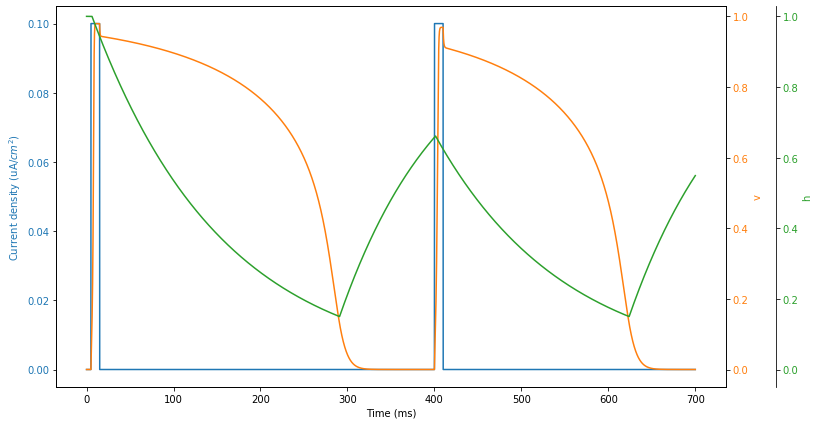

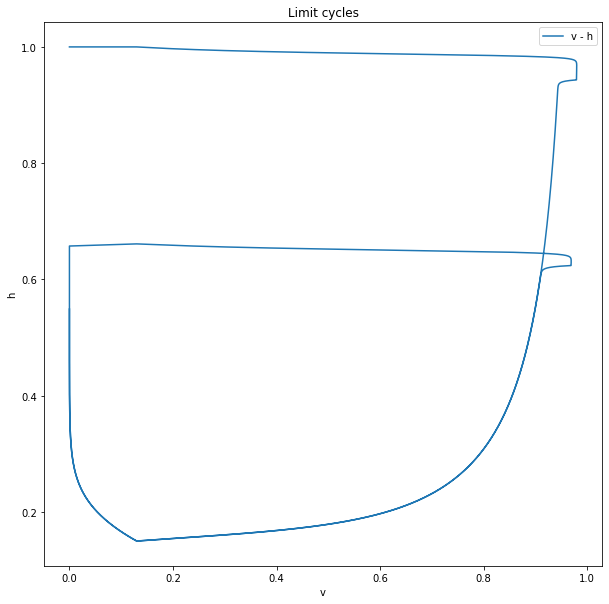

In [5]:
Idv = [Id(t) for t in T]

fig, ax = plt.subplots(figsize=(12, 7))

# stimulus
color = 'tab:blue'
ax.plot(T, Idv, color=color)
ax.set_xlabel('Time (ms)')
ax.set_ylabel(r'Current density (uA/$cm^2$)',color=color)
ax.tick_params(axis='y', labelcolor=color)


# potential
color = 'tab:orange'
ax2 = ax.twinx()
ax2.set_ylabel('v',color=color)
ax2.plot(T, Vy[:, 0],color=color)
ax2.tick_params(axis='y', labelcolor=color)
#plt.grid()

# gate
color = 'tab:green'
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 50))   
ax3.set_ylabel('h',color=color)
ax3.plot(T, Vy[:, 1],color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim(ax2.get_ylim())
#plt.grid()

# Trajectories with limit cycles
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(Vy[:, 0], Vy[:, 1],label='v - h')
ax.set_xlabel("v")
ax.set_ylabel("h")
ax.set_title('Limit cycles')
ax.legend()
#plt.grid()

## Function-based model:
For multiple runs and parameter estimation.

In [12]:
def MitchellSchaeffer(t_in = 0.3, t_out = 6, t_close = 150, t_open = 120):
        # h steady-state value
    def h_inf(Vm=0.0):
        return 1.0 # TODO??

    # Input stimulus
    def Id(t):
        if 5.0 < t < 15.0:
            return 0.1
        elif 400.0 < t < 410.0:
            return 0.1
        return 0.0

    # Compute derivatives
    def compute_derivatives(y, t0):
        dy = np.zeros((2,))

        v = y[0]
        h = y[1]

        dy[0] = ((h*v**2) * (1-v))/t_in - v/t_out + Id(t0) # TODO remove forcing?
        #dy[0] = ((h*v**2) * (1-v))/t_in - v/t_out

        # dh/dt
        if v >= vgate:
            dy[1] = -h/t_close
        else:
            dy[1] = (1-h)/t_open

        return dy
    
    # initial state (v, h)
    Y = np.array([0.0, h_inf()])

    # Solve ODE system
    # V = (v[t0:tmax], h[t0:tmax])
    V = odeint(compute_derivatives, Y, T)
    return V

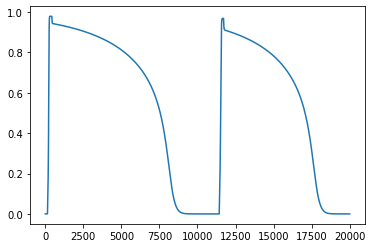

In [13]:
plt.plot(MitchellSchaeffer()[:,0])

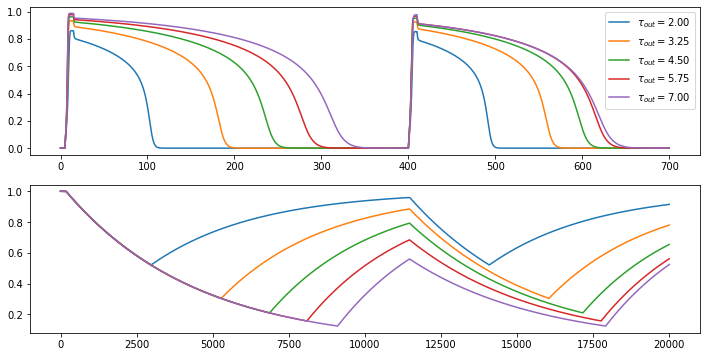

In [14]:
# t_out = 6
fig, axes = plt.subplots(2,1,figsize=(12,6))
for t in np.linspace(2,7,5):
    V = MitchellSchaeffer(t_out=t)
    axes[0].plot(T,V[:,0],label="$\\tau_{out} = %.2f$"%t)
    axes[0].legend()
    axes[1].plot(V[:,1])

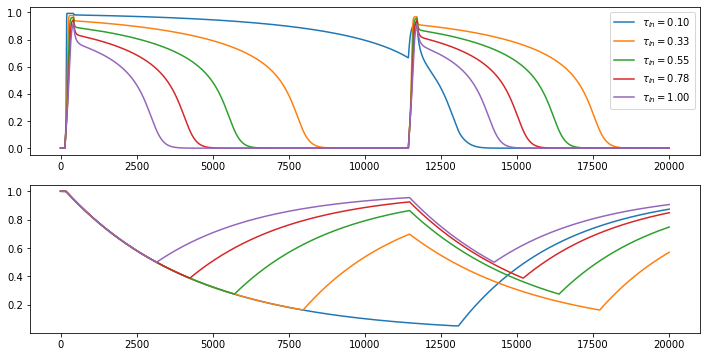

In [15]:
# t_in = 0.3
fig, axes = plt.subplots(2,1,figsize=(12,6))
for t in np.linspace(0.1,1.0,5):
    V = MitchellSchaeffer(t_in=t)
    axes[0].plot(V[:,0],label="$\\tau_{in} = %.2f$"%t)
    axes[0].legend()
    axes[1].plot(V[:,1])

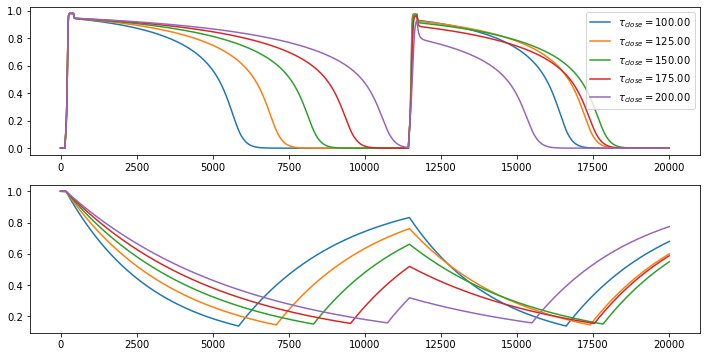

In [16]:
# t_close = 150
fig, axes = plt.subplots(2,1,figsize=(12,6))
for t in np.linspace(100,200,5):
    V = MitchellSchaeffer(t_close=t)
    axes[0].plot(V[:,0],label="$\\tau_{close} = %.2f$"%t)
    axes[0].legend()
    axes[1].plot(V[:,1])

Seems like larger t_close causes a quick second stim to not fully trigger (since h isn't really open?)

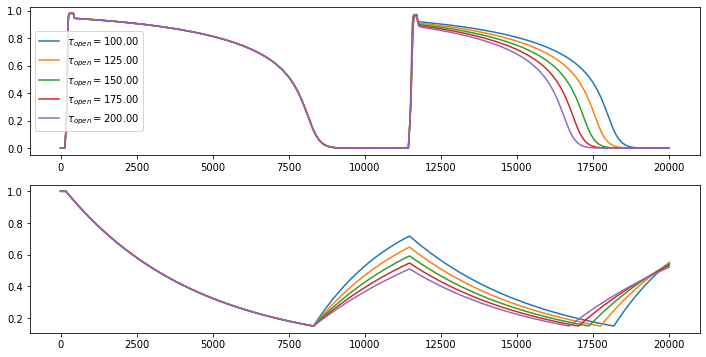

In [17]:
# t_open = 120
fig, axes = plt.subplots(2,1,figsize=(12,6))
for t in np.linspace(100,200,5):
    V = MitchellSchaeffer(t_open=t)
    axes[0].plot(V[:,0],label="$\\tau_{open} = %.2f$"%t)
    axes[0].legend()
    axes[1].plot(V[:,1])

## TODO:
 - Generate time within function
 - return time array and V
 - explore longer delay before second stim